In [47]:
import os
import glob
import grizli
import grizli.utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm


In [48]:
# Spectra tools
import pysynphot as S
import webbpsf

/Users/ross.1333/anaconda3/envs/grizli39/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/ross.1333/pysyn_cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/ross.1333/anaconda3/envs/grizli39/lib/python3.9/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/ross.1333/pysyn_cdbs/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/ross.1333/anaconda3/envs/grizli39/lib/python3.9/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/ross.1333/pysyn_cdbs/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '
**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or co

In [57]:
roman_base_dir = os.getenv('HOME')+'/Dropbox/RomanGRS/products/'
direct_fits = roman_base_dir+"FOV0/roll_0/dither_0x_0y/SCA1/GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
ready_fits = roman_base_dir+"FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
empty_seg = roman_base_dir+"FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits"

In [58]:
file = fits.open(direct_fits)

#commented out rotation
#file[1].data = np.rot90(file[1].data, k=3) # np.rot90 rotates clockwise k times

file[0].header["INSTRUME"] = "ROMAN"
file[0].header["FILTER"] = "d1_"
file[1].header["CONFFILE"] = roman_base_dir+"configuration/Roman.det1.07242020.conf" # This had to be a path, not just a filename; otherwise, grizli can't find the sensitivity fits

file.writeto(ready_fits, overwrite=True)

header = file[1].header # We need to copy this header info into the segmentation file

file.close()

In [73]:
hlss_tbl = Table.read(roman_base_dir+"FOV0/roll_0/dither_0x_0y/SCA1/MOT_SCA1_roll_0_dither_0x_0y_cut_zcut.txt", format="ascii")

In [59]:
SED_dir = roman_base_dir+"FOV0/SEDs/" # Change to your path to directory containing SEDs

# Create F158 Filter Bandpass object
df = Table.read(os.path.join(SED_dir, "wfirst_wfi_f158_001_syn.fits"), format='fits') #close to H-band
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])


In [75]:
from grizli.model import GrismFLT

pad = 100 # Objects near the edge of the detector may have a trace with a center of the detector. Padding ensures it will still disperse
roman = GrismFLT(direct_file=ready_fits, seg_file=empty_seg, pad=pad)



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


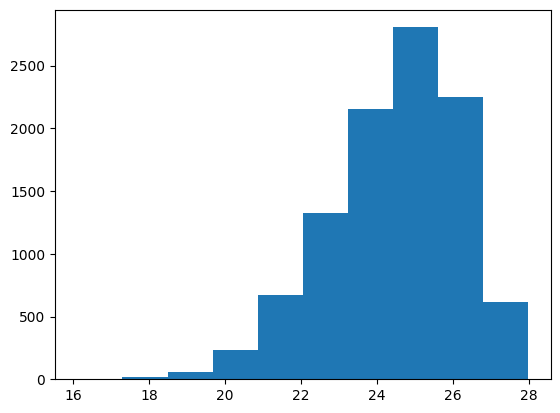

In [9]:
#look at distribution in magnitude for stars
sel_star = hlss_tbl["MODIMAGE"] != 1
plt.hist(hlss_tbl[sel_star]['MAG_F1500W'])
plt.show()

In [10]:
# Read in star spectrum
src = webbpsf.specFromSpectralType("G0V", catalog="phoenix")
wave = np.linspace(10000, 20000, 10000)
flux = src(wave).value
star_spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstroms", fluxunits="flam")


In [77]:
# STAR generic circle shape
gen_circle = lambda x, y, x_0, y_0: (x-x_0)**2 + (y-y_0)**2

In [81]:
def get1d_spec(image,minl=1e4,maxl=2e4,res=25,minx=-400,maxx=599):
    #~12 angstroms per pixel
    nbin = int((maxl-minl)*1.0001/res)
    fluxl = np.zeros(nbin)
    npixl = np.zeros(nbin)
    segv = image.seg.nonzero()
    lamvl = np.arange(minl+res/2.,maxl,res)
    for i in range(0,len(segv[0])):
        xp = segv[1][i]
        yp = segv[0][i]
        #print(xp,yp)
        for dx1 in range(minx,maxx):
            #dx = (dx1,dx1+1)
            dy, lam = image.conf.get_beam_trace(x=xp-image.pad[0], y=yp-image.pad[1], dx=dx1, beam='A')
            #print(dx1,dy,lam)
            dyv = dy
            dxv = dx1
            lamv = lam
            #print(dx1,dy,lam)
            #for lamv,dyv,dxv in zip(lam,dy,dx):
                #print(lamv,dyv,dxv)
            if lamv > minl and lamv < maxl:
                ypf = int(yp+dyv)
                xpf = int(xp+dxv)
                if ypf < len(image.model[0]) and xpf < len(image.model[0]):
                    modv = image.model[ypf][xpf]
                    binv = int((lamv-minl)/res)
                    fluxl[binv] += modv
                    npixl[binv] += 1.
                        #print(lamv,modv,ypf,xpf)
                    #else:
                    #    print(segv,ypf,xpf)
    return lamvl,fluxl,npixl

In [105]:
#get first star between 23rd and 24th magnitude, create grism image, extract spectrum
roman_temp = GrismFLT(direct_file=ready_fits, seg_file=empty_seg, pad=pad)
roman_flat = GrismFLT(direct_file=ready_fits, seg_file=empty_seg, pad=pad)

def plot_extract_star_spec(star_type='G0V',cat="phoenix",github_dir='/Users/ross.1333/Documents/GitHub/',minlam=1e4,maxlam=2e4):
    N = 0
    file = fits.open(direct_fits)
    # Read in star spectrum
    if cat == "phoenix":
        src = webbpsf.specFromSpectralType(star_type, catalog="phoenix")
        wave = np.linspace(10000, 20000, 10000)
        flux = src(wave).value
    if cat == "JC":
        tempdir = github_dir+'star_fields/data/SEDtemplates/'
        temp = np.loadtxt(tempdir+star_type).transpose()
        wave = temp[0]
        sel = wave > minlam
        sel &= wave < maxlam
        wave = wave[sel]
        flux = temp[1]
        flux = flux[sel]
    star_spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstroms", fluxunits="flam")
    
    #for row in hlss_tbl:
    #if row["MODIMAGE"] == 1 and row["MAG_F1500W"] > 23 and row["MAG_F1500W"] < 24 and row["X_IMAGE"] > 600 and row["X_IMAGE"]< 3500:# and row['Z'] > 1 and row['Z'] < 2:
    temp_seg = np.zeros((4288,4288), dtype="float32") # Grizli expects arrays to have dtype="float32"
            #print(row["X_IMAGE"],row['Y_IMAGE'])
            #id = row["NUMBER"]
    id = 1
    mag = 22#row["MAG_F1500W"]
    x_0 = 2000 #row["X_IMAGE"] + 100 # Add 100 to account for padding
    y_0 = 2000 #row["Y_IMAGE"] + 100 

    radius = 5 
    circ = lambda x, y: gen_circle(x, y, x_0, y_0) <= (radius ** 2) # faster to compare squares than sqrt (I think)

    # Define cutout bounds
    x_min = max(int(x_0 - radius + 1), 0)       # max/min ensures we stay on the detector (plus padding)
    x_max = min(int(x_0 + radius + 1), 4288)    # The +1 is so we've got a bit of padding, to ensure our cutout's not rounding down too far
    y_min = max(int(y_0 - radius + 1), 0)
    y_max = min(int(y_0 + radius + 1), 4288)

    # Create Meshgrid within bounds
    x = np.arange(x_min, x_max)
    y = np.arange(y_min, y_max)
    x_grid, y_grid = np.meshgrid(x, y)

    condition = circ(x_grid, y_grid)
    
    temp_seg[y_min:y_max, x_min:x_max][np.where(condition)] = id #

    roman_temp.seg = temp_seg#np.rot90(temp_seg, k=3) # temp_seg is built using non-rotated coordinates; rotate temp_seg so it lines up with our rotated direct image
    roman_flat.seg = temp_seg
    # SIMULATION

    # Adjust spectrum scale using F158 Filter Bandpass object and star magnitude
    spec = star_spec.renorm(mag, "abmag", bp)
    spec.convert("flam")
    
    #tp = 'G0V star'
    # By default, grizli tries to compute a cutout size. This cutout size is not large enough for the roman grism.
    # In 4) FOV0_sims/notebooks/dy-by-optimize.ipynb, Keith estimates the maximum needed size to be 77 for detector 1.
    # See that notebook for more details
    roman_temp.compute_model_orders(id=id, mag=mag, compute_size=False, size=77, in_place=True, store=False,
                       is_cgs=True, spectrum_1d=[spec.wave, spec.flux])
    #roman_temp.compute_full_model(ids=[id], mags=[mag], verbose=True)
    #compute_full_model
    #sel = roman_temp.model > 0
    #dx = (0,0)
    #print(x_0,roman_temp.pad)
    #dy, lam = roman_temp.conf.get_beam_trace(x=x_0-roman_temp.pad, y=y_0-roman_temp.pad, dx=dx, beam='A')
    #dx = (-600,400)
    #dy, lam = roman_temp.conf.get_beam_trace(x=x_0-roman_temp.pad, y=y_0-roman_temp.pad, dx=dx, beam='A')

    #print('wavelength for dx = -600 is '+str(round(lam[0],3))+' dy is ' +str(dy[0])+'; 400 is '+str(round(lam[1],3))+' dy is '+str(dy[1]))
    #titl = 'id '+str(id)+' a mag '+str(round(mag,3))+' '+tp
    lamv,flux,pix = get1d_spec(roman_temp)

    flatflux = np.ones(len(wave))
    flatspec = S.ArraySpectrum(wave=wave, flux=flatflux, waveunits="angstrom", fluxunits="flam").redshift(0)
    flatspec = flatspec.renorm(mag, "abmag", bp)
    flatspec.convert("flam")
    roman_flat.compute_model_orders(id=id, mag=mag, compute_size=False, size=77, in_place=True, store=False,
                           is_cgs=True, spectrum_1d=[flatspec.wave, np.ones(len(flatspec.wave))])#flatspec.flux])
    _,flatflux,flatpix = get1d_spec(roman_flat)

    plt.plot(lamv,flux/flatflux,label='simulated extracted spectrum')
    plt.plot(spec.wave, spec.flux,label='input',zorder=0)#*3.9e18,label='input x 3.9e18',zorder=0)

    plt.title('stellar type '+star_type+' F1500 mag '+str(round(mag,1)))
    plt.ylabel('flux')
    plt.xlabel('wavelength (angstroms)')
    plt.legend()
    plt.show()        

    #        N += 1
    #    if N >0:
    #        break

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/Ro

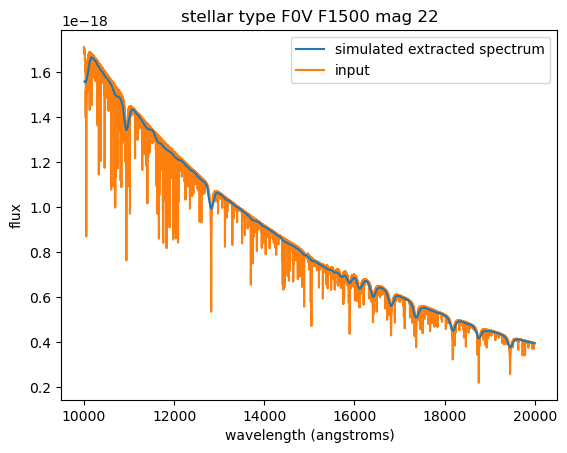

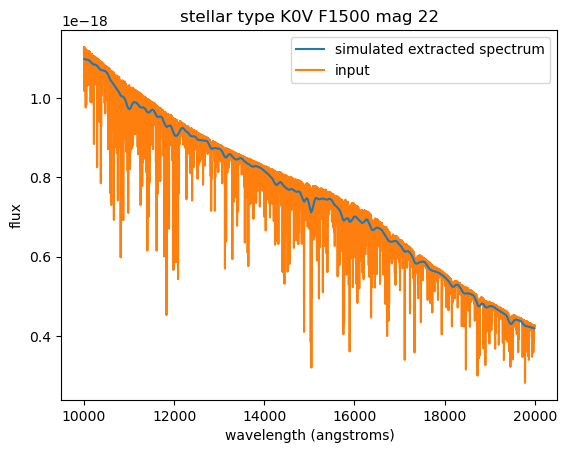

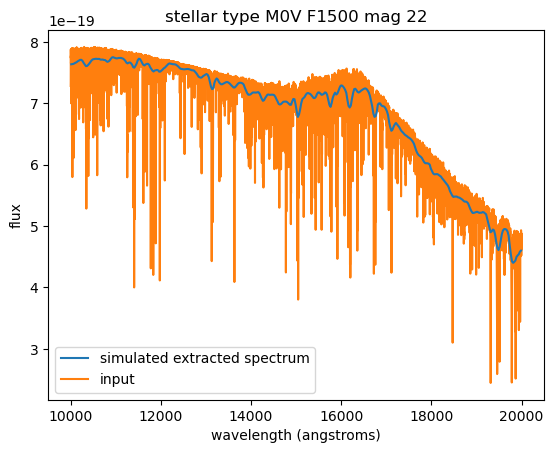

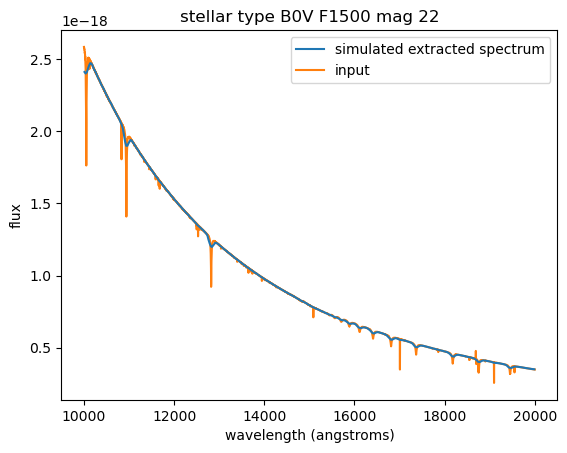

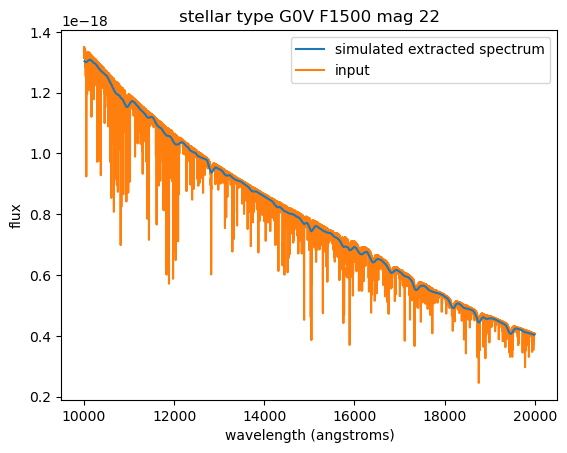

In [106]:
stellar_types = ['F0V','K0V','M0V','B0V','G0V']
for tp in stellar_types:
    plot_extract_star_spec(star_type=tp)

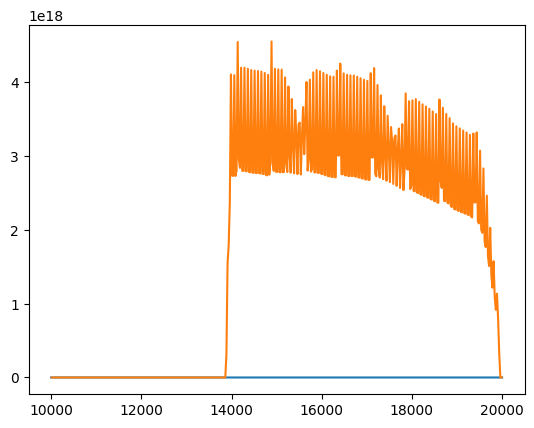

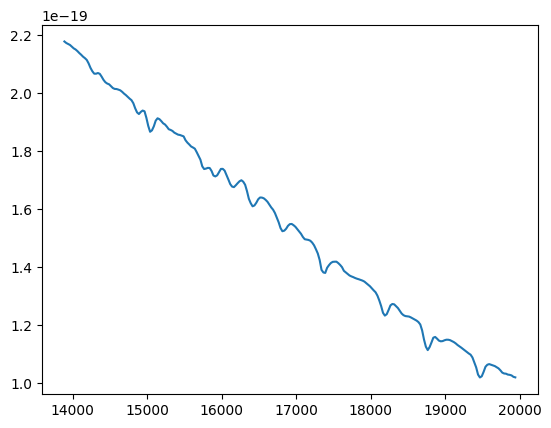

In [26]:
flatflux = np.ones(len(wave))
flatspec = S.ArraySpectrum(wave=wave, flux=flatflux, waveunits="angstrom", fluxunits="flam").redshift(0)
flatspec = flatspec.renorm(mag, "abmag", bp)
flatspec.convert("flam")

plt.plot(flatspec.wave, flatspec.flux)#/flatpix)

roman_flat.compute_model_orders(id=id, mag=mag, compute_size=False, size=77, in_place=True, store=False,
                           is_cgs=True, spectrum_1d=[flatspec.wave, np.ones(len(flatspec.wave))])#flatspec.flux])
_,flatflux,flatpix = get1d_spec(roman_flat)
plt.plot(lamv,flatflux)#/flatpix)
plt.show()
plt.show()

plt.plot(lamv,flux/flatflux)
plt.show()

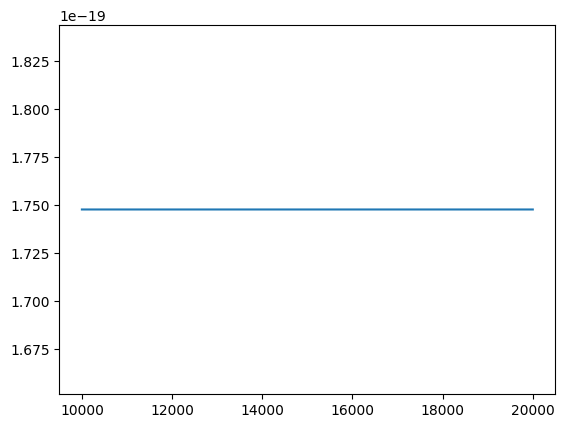

In [29]:
plt.plot(flatspec.wave, flatspec.flux)

In [98]:
dxl = np.arange(-600,400)
dy, lam = roman.conf.get_beam_trace(x=4088, y=0, dx=dxl, beam='A')

In [41]:
maxl = 0
xv = 0
yv = 0
while maxl < 20000:
    dxl = [-xv,-xv+1]
    dy, lam = roman.conf.get_beam_trace(x=xv, y=yv, dx=dxl, beam='A')
    maxl = max(lam)
    xv += 1

In [42]:
xv,dy,lam

(357,
 array([68.87525079, 68.86289696]),
 array([20004.50871665, 19993.55444921]))

In [38]:
minl = 20000
xv = 4088
yv = 0
while minl > 10000 and xv >= 0:
    dxl = [4088-xv,4088-xv-1]
    dy, lam = roman.conf.get_beam_trace(x=xv, y=yv, dx=dxl, beam='A')
    minl = min(lam)
    xv -= 1

In [39]:
xv

3554

In [37]:
minl

16131.101399925315

In [40]:
dy

array([37.26534059, 37.28176999])

In [53]:
maxl = 0
xv = 0
yv = 4088
y_max = 10000
#while (maxl < 20000) and (y_max > 4088):
for xv in range(0,1000):
    dxl = [-xv,-xv+1]
    dy, lam = roman.conf.get_beam_trace(x=xv, y=yv, dx=dxl, beam='A')
    maxl = max(lam)
    y_max = max(dy)+yv
    if maxl > 20000:
        while y_max > 4088:
            yv -= 1
            dy, lam = roman.conf.get_beam_trace(x=xv, y=yv, dx=dxl, beam='A')
            y_max = max(dy)+yv
        break

In [54]:
xv,yv

(380, 4073)

In [71]:
yv = 4088
y_max = 10000
#while (maxl < 20000) and (y_max > 4088):
#for xv in range(4088,3088):
for i in range(0,1000):
    xv = 4088-i
    dxl = [4088-xv,4088-xv-1]
    #print(dxl)
    dy, lam = roman.conf.get_beam_trace(x=xv, y=yv, dx=dxl, beam='A')
    minl = min(lam)
    y_max = max(dy)+yv
    if minl < 10000:
        while y_max > 4088:
            yv -= 1
            dy, lam = roman.conf.get_beam_trace(x=xv, y=yv, dx=dxl, beam='A')
            y_max = max(dy)+yv
        break

In [72]:
xv,yv

(3586, 4088)

In [74]:
minl,dxl

(9994.82333156702, [502, 501])

In [97]:
roman.conf.get_beam_trace(x=3586, y=4088, dx=0, beam='A')

(-5.304867643875197, 15410.967576383999)

In [69]:
np.arange(4088,3088)

array([], dtype=int64)

In [75]:
y_max

4082.1384999967568

In [76]:
roman.conf.get_beam_trace(x=-100, y=0, dx=[100,101], beam='A')

(array([65.76857911, 65.75594312]), array([15052.77224696, 15041.76064272]))

In [77]:
grizli.grismconf

<module 'grizli.grismconf' from '/Users/ross.1333/Documents/GitHub/grizli/grizli/grismconf.py'>

In [78]:
conf = grizli.grismconf.aXeConf(conf_file=roman_base_dir+"configuration/Roman.det1.07242020.conf")

In [79]:
conf.get_beam_trace(x=-100, y=0, dx=[100,101], beam='A')

(array([65.76857911, 65.75594312]), array([15052.77224696, 15041.76064272]))

In [83]:
import sys
sys.path.append(os.environ['HOME']+'/Documents/GitHub/observing-program/py')

In [86]:
import grism_dispersion

In [88]:
import importlib

In [89]:
importlib.reload(grism_dispersion)

<module 'grism_dispersion' from '/Users/ross.1333/Documents/GitHub/observing-program/py/grism_dispersion.py'>

In [90]:
myconf = grism_dispersion.aXeConf(conf_file=roman_base_dir+"configuration/Roman.det1.07242020.conf")
myconf.get_beam_trace(x=-100, y=0, dx=[100,101], beam='A')

(array([65.76857911, 65.75594312]), array([15052.77224696, 15041.76064272]))

In [91]:
myconf.conf

OrderedDict([('INSTRUMENT', 'ROMAN'),
             ('CAMERA', 'IR'),
             ('SCIENCE_EXT', 'SCI'),
             ('DQ_EXT', 'DQ'),
             ('ERRORS_EXT', 'ERR'),
             ('DQMASK', 16383.0),
             ('RDNOISE', 0.0),
             ('EXPTIME', 'EXPTIME'),
             ('POBJSIZE', 1.0),
             ('SMFACTOR', 1.0),
             ('DRZRESOLA', 10.764),
             ('DRZSCALE', 0.11),
             ('DRZLAMB0', 12850.0),
             ('TELAREA', 45238.93),
             ('BEAMA', array([-800.,  800.])),
             ('MMAG_EXTRACT_A', 30.0),
             ('MMAG_MARK_A', 30.0),
             ('XOFF_A', 0.0),
             ('YOFF_A', 0.0),
             ('SENSITIVITY_A', 'sens_0720_2020.fits'),
             ('DYDX_ORDER_A', 2.0),
             ('DYDX_A_0',
              array([ 6.64449e+01, -5.79476e-03, -1.24014e-02,  0.00000e+00,
                     -1.86114e-08,  0.00000e+00])),
             ('DYDX_A_1',
              array([-1.25705e-02, -8.97764e-07,  2.83491e-06,  0.

In [92]:
conf.orders['A']

2

In [93]:
conf.field_dependent(0,0,conf.conf['XOFF_{0}'.format('A')])

0.0

In [94]:
conf.field_dependent(0,0,conf.conf['YOFF_{0}'.format('A')])

0.0

In [96]:
myconf.get_beam_trace(x=-100, y=0, dx=[100,101,102], beam='A')

(array([65.76857911, 65.75594312, 65.74330559]),
 array([15052.77224696, 15041.76064272, 15030.74897488]))

In [2]:
from astropy.table import Table

In [107]:
stars00 = Table.read('/Users/ross.1333/Documents/GitHub/star_fields/py/stars_radec00.ecsv')

In [110]:
stars30 = Table.read('/Users/ross.1333/Documents/GitHub/star_fields/py/stars_radec30-30.ecsv')

In [113]:
stars750 = Table.read('/Users/ross.1333/Documents/GitHub/star_fields/py/stars_radec750.ecsv')

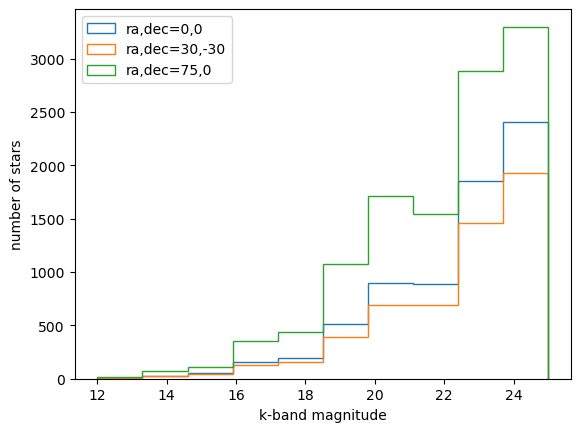

In [115]:
plt.hist(stars00['magnitude'],label='ra,dec=0,0',histtype='step',range=(12,25))
plt.hist(stars30['magnitude'],label='ra,dec=30,-30',histtype='step',range=(12,25))
plt.hist(stars750['magnitude'],label='ra,dec=75,0',histtype='step',range=(12,25))
plt.xlabel('k-band magnitude')
plt.ylabel('number of stars')
plt.legend()
plt.show()

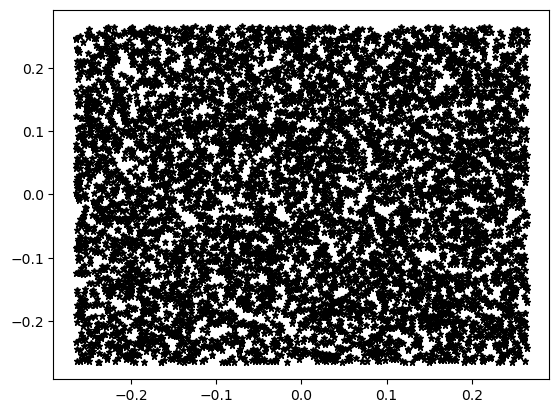

In [125]:
plt.plot(stars00['RA'],stars00['DEC'],'k*',markersize=5)

In [12]:
stars.dtype.names

('index',
 'Xpos',
 'Ypos',
 '8',
 '8again',
 '0',
 'star_template_index',
 '0again',
 'magnitude',
 '0again2',
 '1',
 '0again3',
 '0again4',
 'mag_again',
 'RA',
 'DEC')

In [29]:
temp_ind = stars['star_template_index'] - 58*(stars['star_template_index']//58)

(array([2166., 4197.,  559.,    5.,    0.,    0.,   38.,    0.,    0.,
          26.]),
 array([10. , 14.3, 18.6, 22.9, 27.2, 31.5, 35.8, 40.1, 44.4, 48.7, 53. ]),
 <BarContainer object of 10 artists>)

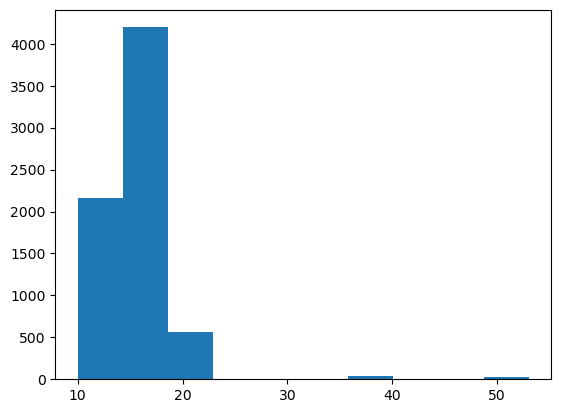

In [30]:
plt.hist(temp_ind)
#plt.hist(stars['star_template_index'])

In [15]:
template_index = 29
template_starting_point = 1
int(8+template_index*1+(2*template_index)*2 + template_starting_point)  

154

In [16]:
templates = open('/Users/ross.1333/Documents/GitHub/star_fields/data/SEDtemplates/input_spectral_STARS.lis').readlines()

In [20]:
templates[0]

'garbage\n'

In [21]:
stars['template'] = templates[stars['star_template_index']]

TypeError: only integer scalar arrays can be converted to a scalar index

In [70]:
ng = 0
#for ind in stars['star_template_index']:
tmpl = []
for ind in temp_ind:
    tmp = templates[int(ind)].strip('\n')
    if tmp not in tmpl:
        tmpl.append(tmp.strip('\n'))
    if 'garbage' in tmp:
        ng += 1


In [71]:
ng,tmpl

(0,
 ['ukk2iii.dat',
  'ukk0iii.dat',
  'uka0v.dat',
  'ukg0iii.dat',
  'uka3v.dat',
  'ukf5v.dat',
  'ukg0v.dat',
  'ukk2v.dat',
  'ukm1v.dat',
  'ukm3v.dat',
  'ukm5v.dat',
  'ukm6v.dat',
  'L3.5_LTDDA_example.txt',
  'fake_WD_template.txt',
  'L5_2MASS1821p1414_full_fluxed_AA.txt',
  'T2_SDSS1254m0122_full_fluxed_AA.txt'])

In [60]:
src = webbpsf.specFromSpectralType("G0V", catalog="phoenix")
wave = np.linspace(10000, 20000, 10000)
flux = src(wave).value
star_spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstroms", fluxunits="flam")
mag = 22
spec = star_spec.renorm(mag, "abmag", bp)
spec.convert("flam")

In [ ]:
tmp

'fake_WD_template.txt\n'

In [37]:
tempdir = '/Users/ross.1333/Documents/GitHub/star_fields/data/SEDtemplates/'
temp = np.loadtxt(tempdir+tmp.strip('\n'))

In [40]:
len(temp.transpose())

5

In [39]:
temp[0]

array([1.1500e+03, 2.7063e-02, 3.0047e-02, 2.7063e-02, 0.0000e+00])

In [50]:
star_spec_t = S.ArraySpectrum(wave=temp.transpose()[0], flux=temp.transpose()[1], waveunits="angstroms", fluxunits="flam")

In [61]:
spect = star_spec_t.renorm(mag, "abmag", bp)
spect.convert("flam")

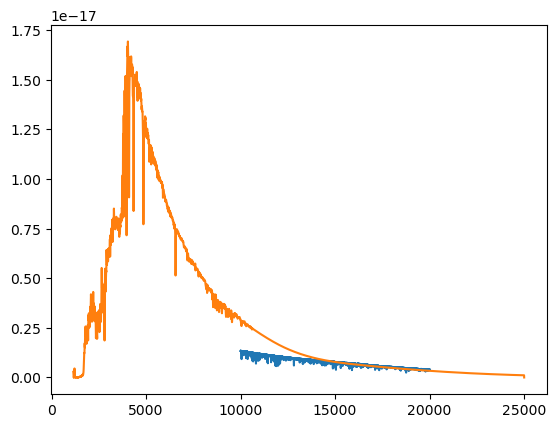

In [62]:
plt.plot(spec.wave, spec.flux)
plt.plot(spect.wave, spect.flux)

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/Ro

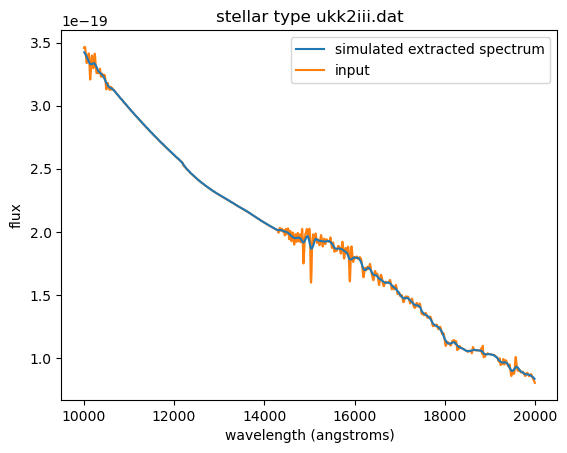

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/Ro

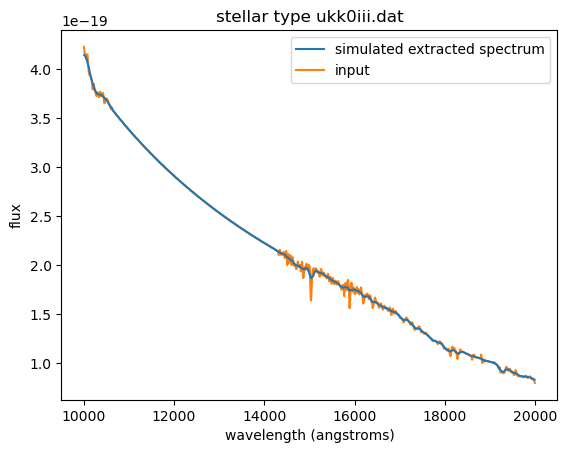

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/Ro

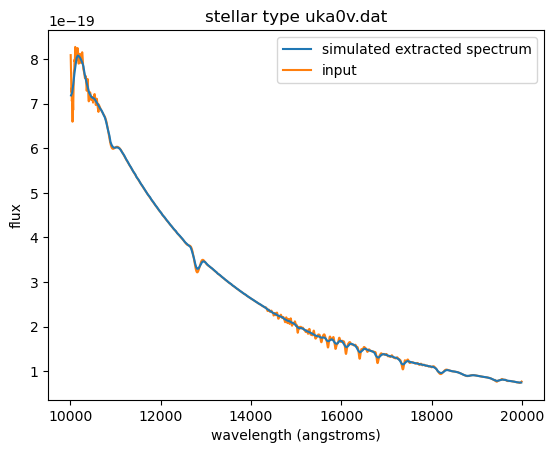

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/Ro

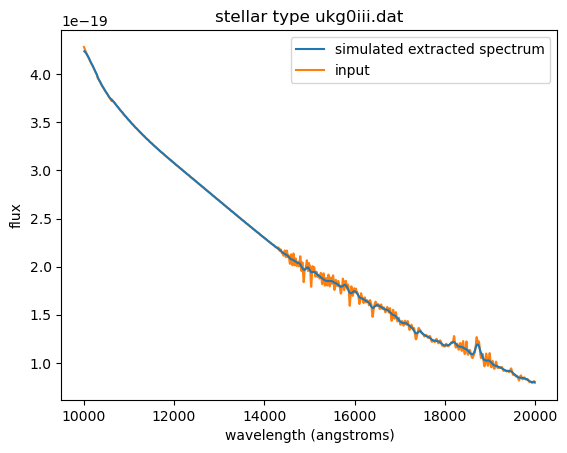

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/Ro

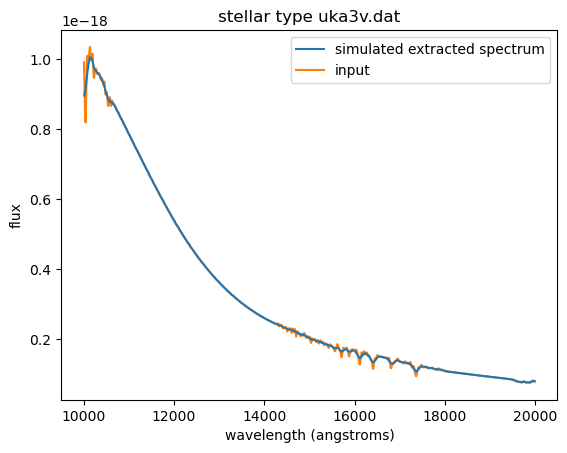

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/Ro

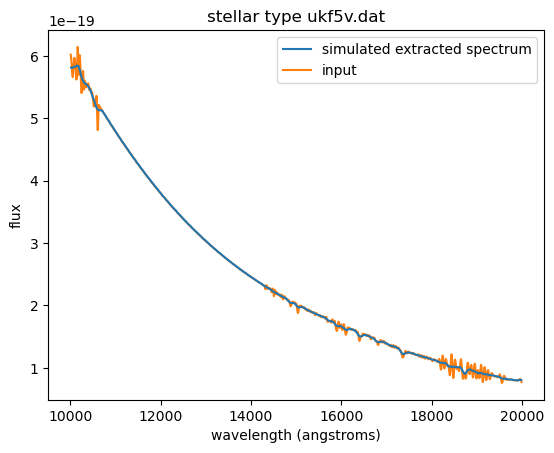

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/Ro

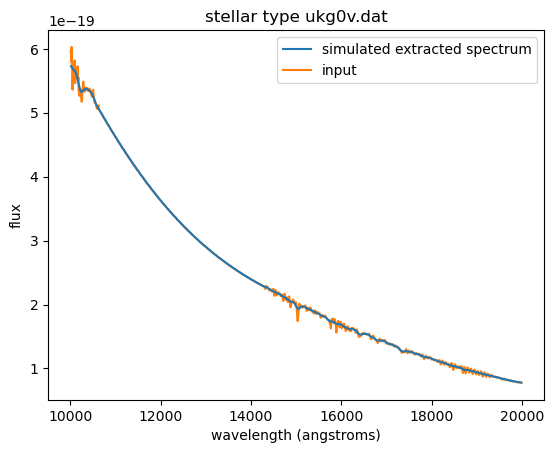

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/Ro

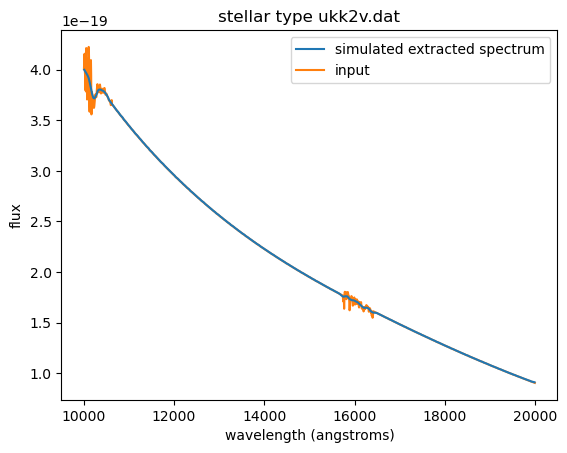

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/Ro

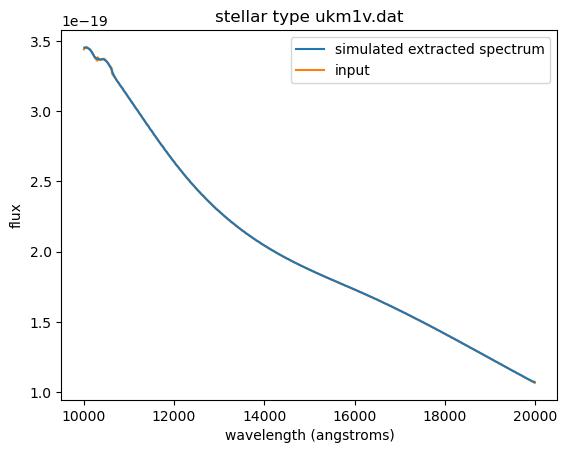

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/Ro

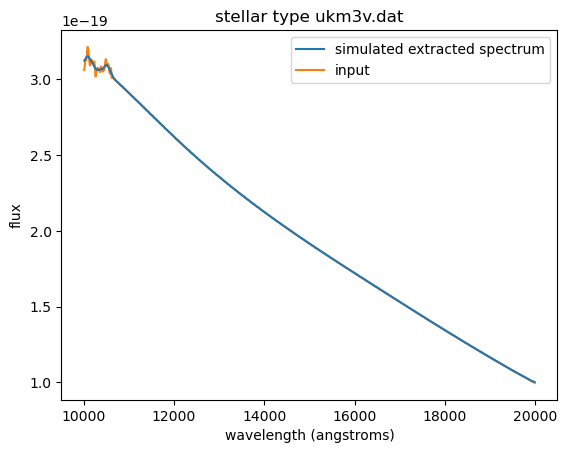

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/Ro

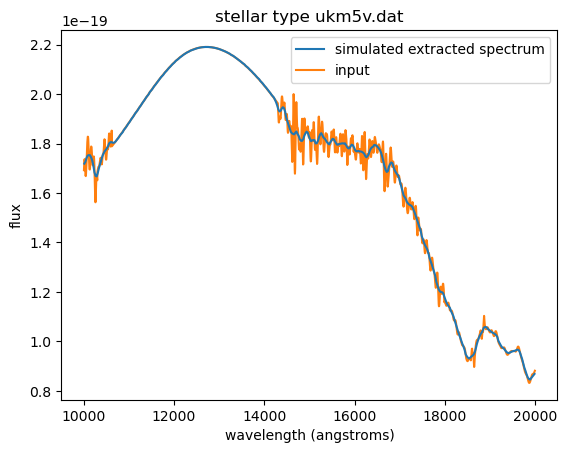

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/Ro

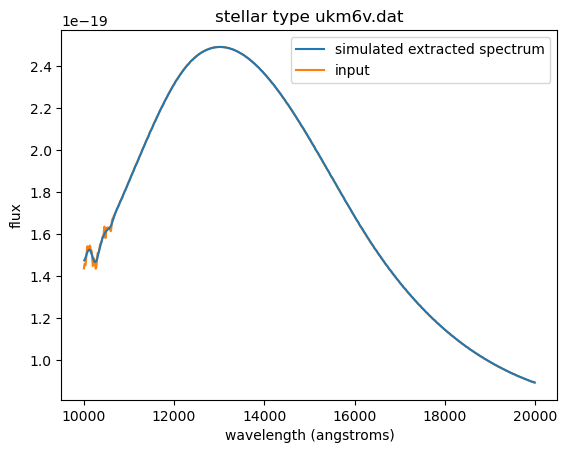

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/Ro

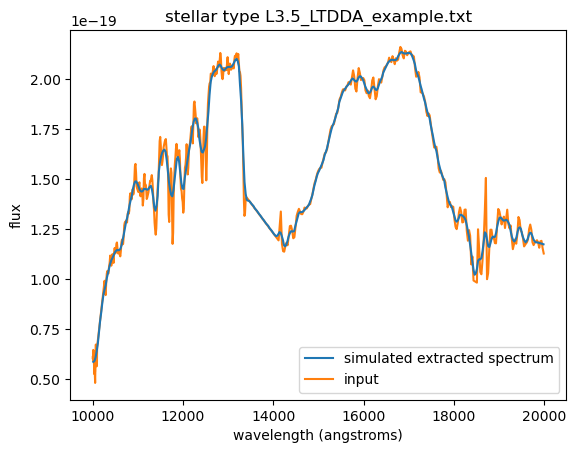

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/Ro

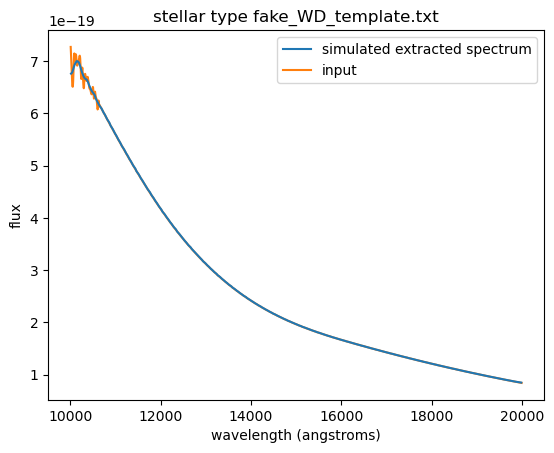

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/Ro

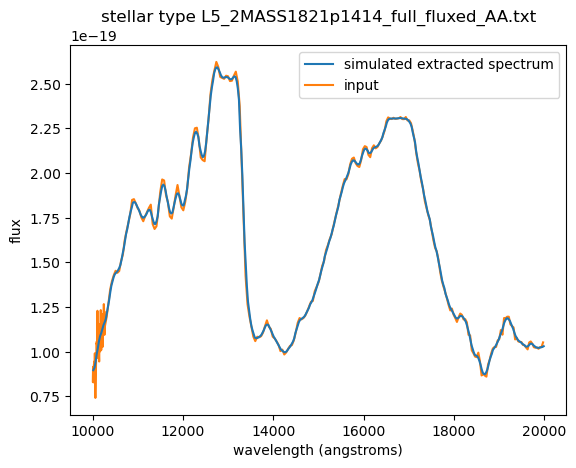

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/Ro

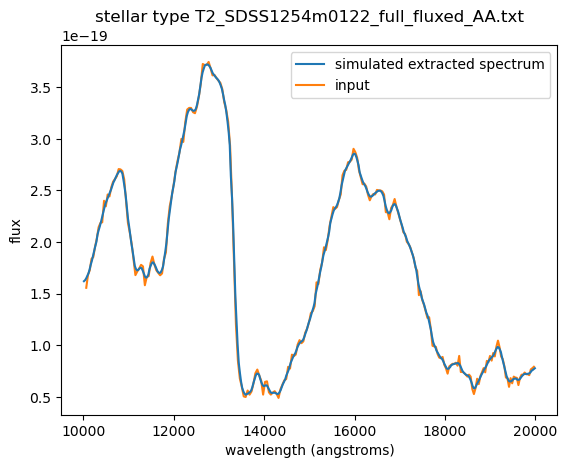

In [88]:
for tmp in tmpl:
    plot_extract_star_spec(star_type=tmp,cat='JC')

In [92]:
os.getcwd()

'/Users/ross.1333/Documents/GitHub/grizli/notebooks'